In [8]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

from pathlib import Path

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
%load_ext autoreload
%autoreload 2
from utils import *

# scperturb package
sys.path.insert(1, '../../package/src/')
from scperturb import *

from pathlib import Path
figure_path = Path('../figures/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATADIR = Path('/data/gpfs-1/users/peidlis_c/work/data/perturbation_resource_paper')
TEMPDIR = Path("/fast/scratch/users/peidlis_c/perturbation_resource_paper/")

In [3]:
# Load list of ATAC datasets available via scPerturb
df = pd.read_excel('../../metadata/scperturb_dataset_info.xlsx')  # supplemental table
df = df[df['Modality = Data type'].isin(['ATAC', 'ATAC + protein'])]
df.index = [a if pd.isna(b) else a+'_'+b for a, b in zip(df[df.columns[0]], df[df.columns[1]])]
datasets_atac = list(df.index)
print(datasets_atac)

['Liscovitch-BrauerSanjana2021_K562_1', 'Liscovitch-BrauerSanjana2021_K562_2', 'MimitouSmibert2021', 'PierceGreenleaf2021_K562', 'PierceGreenleaf2021_MCF7', 'PierceGreenleaf2021_GM12878']


In [4]:
features = ['ChromVar', 'LSI_embedding', 'gene_scores', 'peak_bc']

# MimitouSmibert2021

In [6]:
dataset = datasets_atac[2]
# compute e-distances in each feature
eds = {}
for feature in tqdm(features):
    adata = sc.read(TEMPDIR / f'tmp_ATAC_data_{dataset}_feature_{feature}.h5')
    adata = adata[~pd.isna(adata.obs.perturbation)].copy()
    obsm_key = [x for x in adata.obsm.keys() if feature in x][0]  # select feature embedding
    ed = edist(adata, obs_key='perturbation', obsm_key=obsm_key, verbose=False)
    eds[feature] = cluster_matrix(ed.fillna(0), 'both')

100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


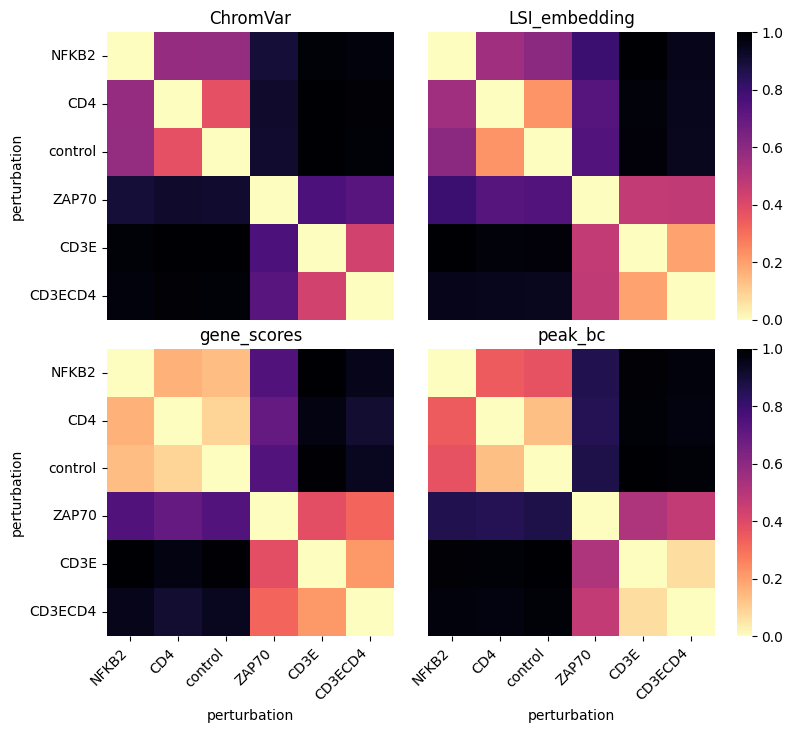

In [9]:
# plot pairwise e-distances
order = ['NFKB2', 'CD4', 'control', 'ZAP70', 'CD3E', 'CD3ECD4']
fig, axss = pl.subplots(2,2,figsize=(10,8), dpi=100, gridspec_kw=dict(wspace=-0.25, hspace=0.1))
for obsm_key, ax in zip(eds.keys(), np.ravel(axss)):
    # M = cluster_matrix(eds[obsm_key], 'both')
    M = eds[obsm_key].loc[order, order]
    M = np.log1p(M)
    M = M/np.max(np.max(M))
    is_right = np.isin(obsm_key, ['LSI_embedding', 'peak_bc'])
    is_bottom = np.isin(obsm_key, ['gene_scores', 'peak_bc'])
    sns.heatmap(M, robust=True, ax=ax, cmap='magma_r', cbar=is_right)
    if is_right: 
        ax.set_ylabel('')
        ax.set_yticks([])
    if not is_bottom: 
        ax.set_xlabel('')
        ax.set_xticks([])
    else:
        ax.set_xticklabels(order, rotation=45, ha='right')
    ax.set_title(obsm_key)
    ax.set_aspect('equal')
pl.savefig(figure_path / f'ATAC_Analysis_{dataset}_heats.pdf', bbox_inches='tight')
pl.show()

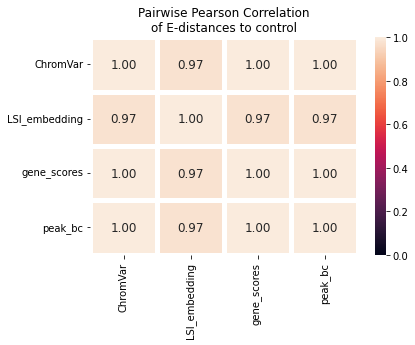

In [24]:
df = pd.DataFrame({feature: eds[feature].loc['control'] for feature in features})
pcorr = df.corr('pearson')
sns.heatmap(pcorr, vmin=0, vmax=1, annot=True, fmt=".2f", linewidth=5, annot_kws={'size': 12})
pl.title('Pairwise Pearson Correlation\nof E-distances to control')
pl.savefig(figure_path / f'ATAC_Analysis_{dataset}_pearson.pdf', bbox_inches='tight')
pl.show()

# Liscovitch-BrauerSanjana2021_K562_1

In [25]:
dataset = 'Liscovitch-BrauerSanjana2021_K562_1'

In [28]:
# compute e-distances in each feature
eds = {}
for feature in tqdm(features):
    adata = sc.read(TEMPDIR / f'tmp_ATAC_data_{dataset}_feature_{feature}.h5')
    adata = adata[~pd.isna(adata.obs.perturbation)].copy()
    obsm_key = [x for x in adata.obsm.keys() if feature in x][0]  # select feature embedding
    ed = edist(adata, obs_key='perturbation', obsm_key=obsm_key, verbose=False)
    eds[feature] = cluster_matrix(ed, 'both')

100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


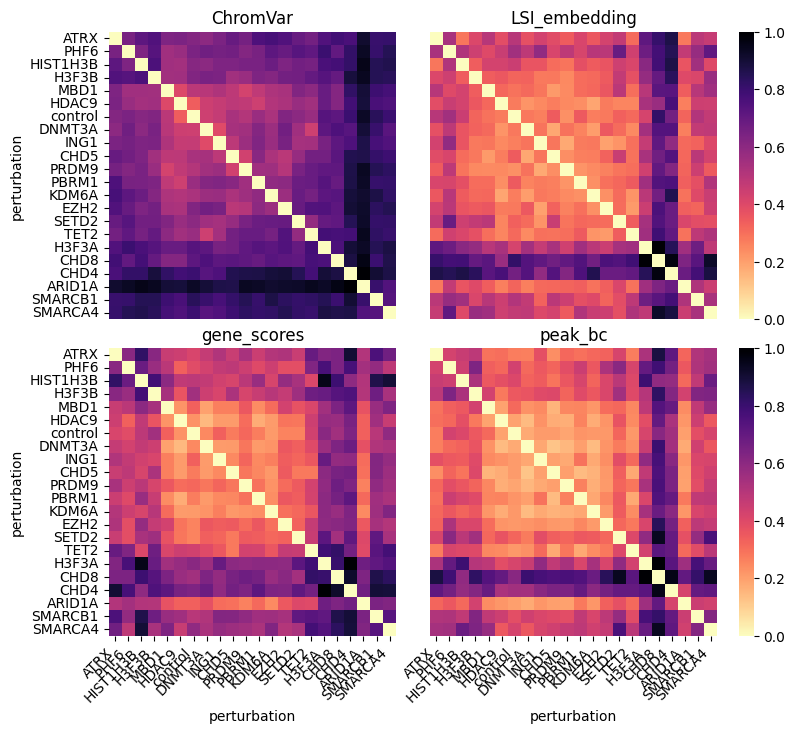

In [29]:
# consensus ordering
idx = eds['LSI_embedding'].index
avg = pd.DataFrame(np.mean(np.array([ed.loc[idx, idx].values for ed in eds.values()]), axis=0), index=idx, columns=idx)
consensus_order = cluster_matrix(avg, 'both').index

# plot pairwise e-distances
fig, axss = pl.subplots(2,2,figsize=(10,8), dpi=100, gridspec_kw=dict(wspace=-0.25, hspace=0.1))
for obsm_key, ax in zip(eds.keys(), np.ravel(axss)):
    # M = cluster_matrix(eds[obsm_key], 'both')
    M = eds[obsm_key].loc[consensus_order, consensus_order]
    M = np.log1p(M)
    M = M/np.max(np.max(M))
    is_right = np.isin(obsm_key, ['LSI_embedding', 'peak_bc'])
    is_bottom = np.isin(obsm_key, ['gene_scores', 'peak_bc'])
    sns.heatmap(M, robust=True, ax=ax, cmap='magma_r', cbar=is_right, vmax=1, vmin=0)
    if is_right: 
        ax.set_ylabel('')
        ax.set_yticks([])
    else:
        ax.set_yticks(np.arange(len(consensus_order))+0.5)
        ax.set_yticklabels(consensus_order)
    if not is_bottom: 
        ax.set_xlabel('')
        ax.set_xticks([])
    else:
        ax.set_xticklabels(consensus_order, rotation=45, ha='right')
    ax.set_title(obsm_key)
    ax.set_aspect('equal')
pl.savefig(figure_path / f'ATAC_Analysis_{dataset}_heats.pdf', bbox_inches='tight')
pl.show()

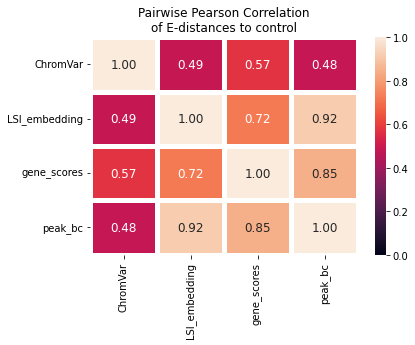

In [30]:
df = pd.DataFrame({feature: eds[feature].loc['control'] for feature in features})
pcorr = df.corr('pearson')
sns.heatmap(pcorr, vmin=0, vmax=1, annot=True, fmt=".2f", linewidth=5, annot_kws={'size': 12})
pl.title('Pairwise Pearson Correlation\nof E-distances to control')
pl.savefig(figure_path / f'ATAC_Analysis_{dataset}_pearson.pdf', bbox_inches='tight')
pl.show()

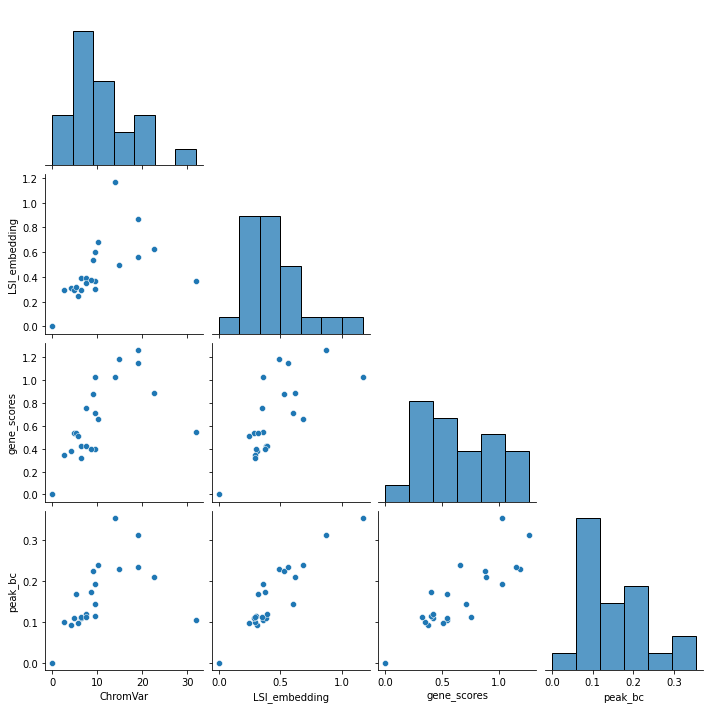

In [31]:
sns.pairplot(data=df, corner=True);

# All

Liscovitch-BrauerSanjana2021_K562_1


100%|██████████| 4/4 [00:06<00:00,  1.50s/it]


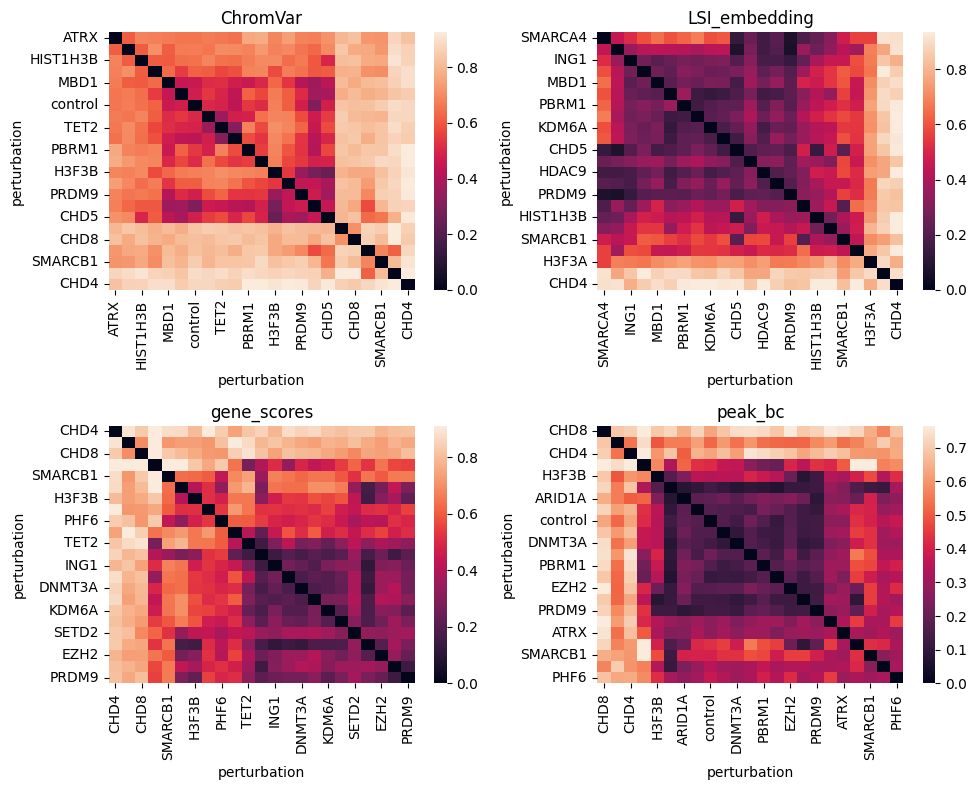

Liscovitch-BrauerSanjana2021_K562_2


100%|██████████| 4/4 [00:29<00:00,  7.41s/it]


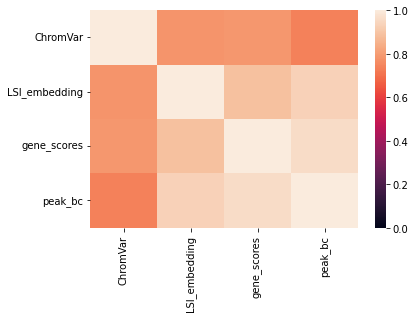

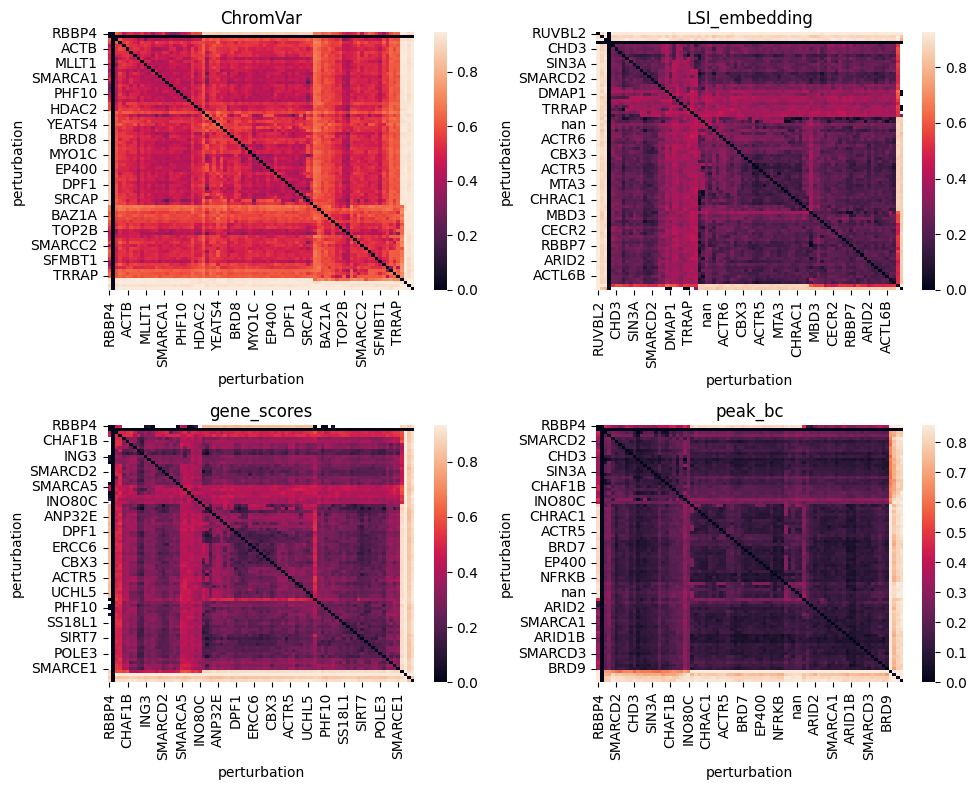

MimitouSmibert2021


100%|██████████| 4/4 [00:08<00:00,  2.23s/it]


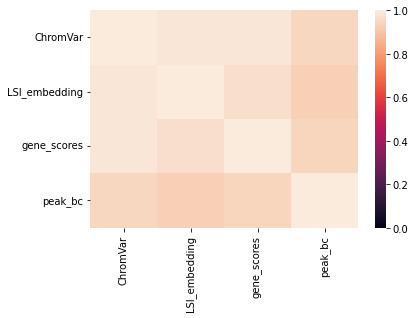

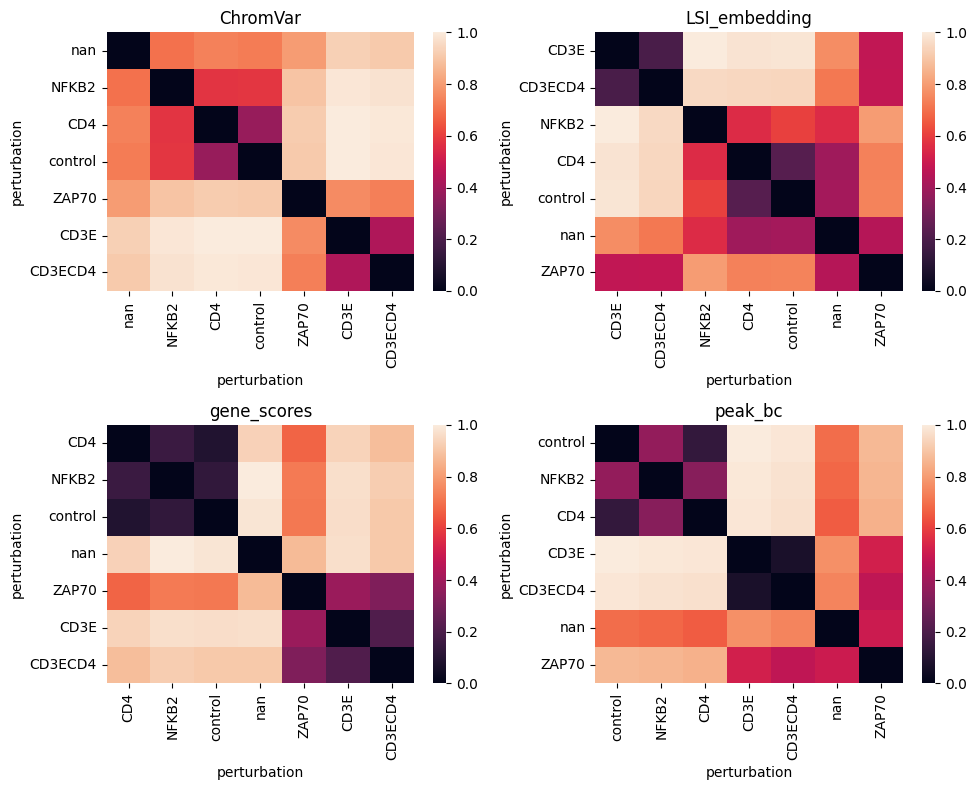

PierceGreenleaf2021_K562


100%|██████████| 4/4 [01:25<00:00, 21.45s/it]


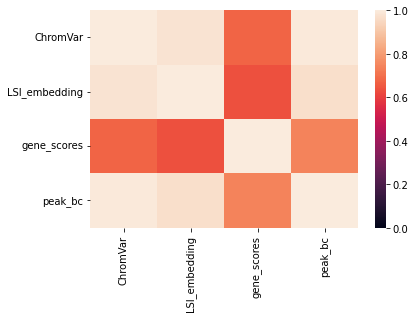

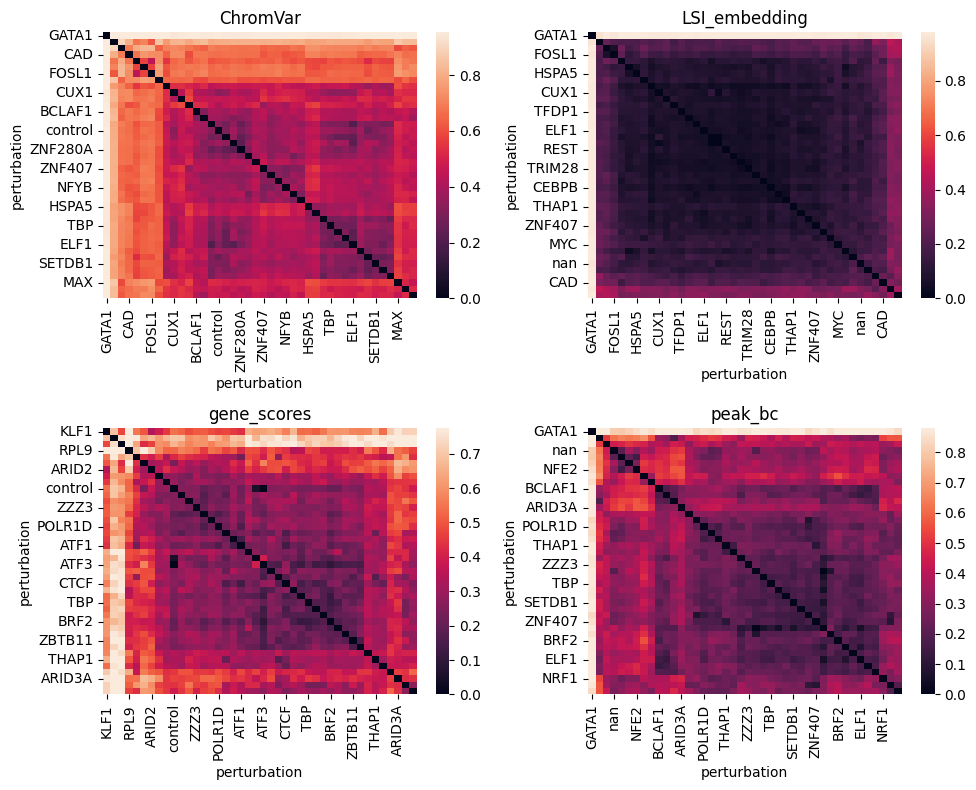

PierceGreenleaf2021_MCF7


100%|██████████| 4/4 [00:33<00:00,  8.42s/it]


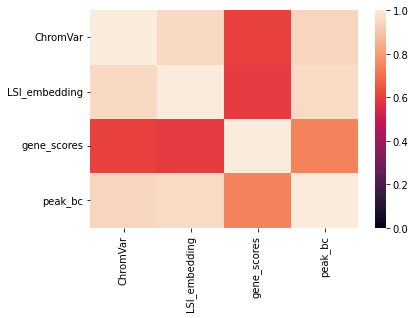

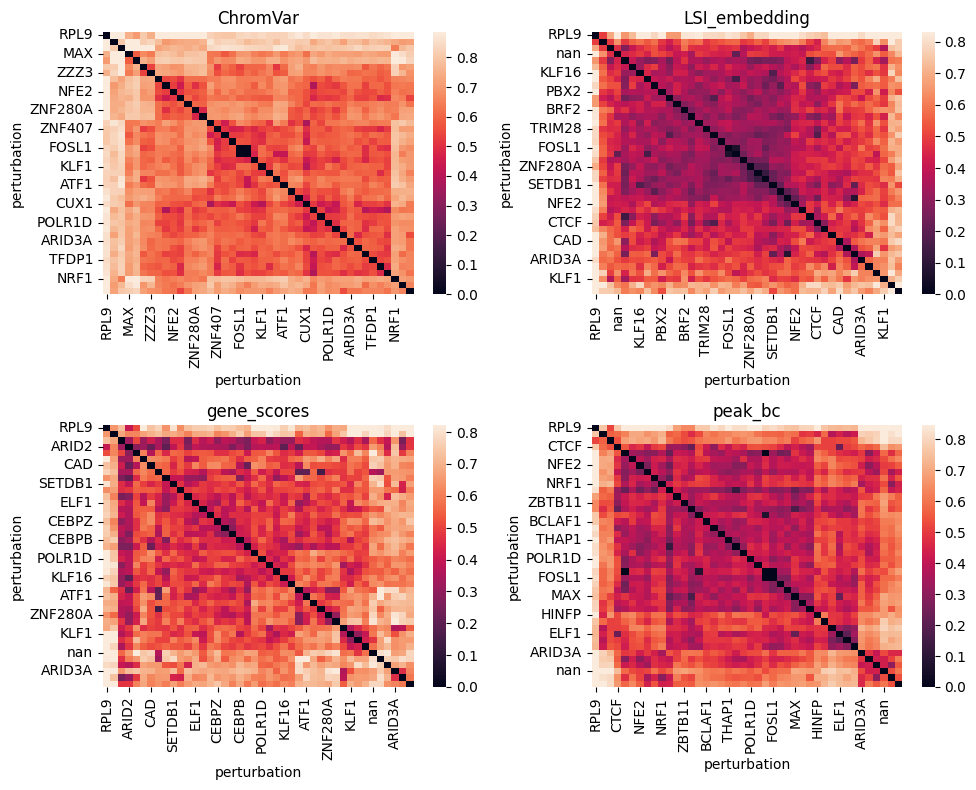

PierceGreenleaf2021_GM12878


100%|██████████| 4/4 [00:47<00:00, 11.94s/it]


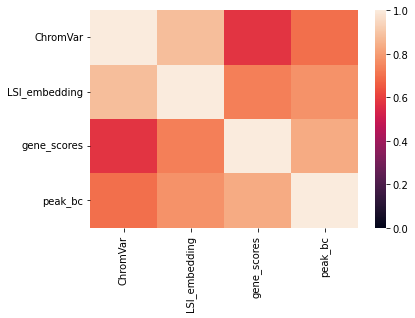

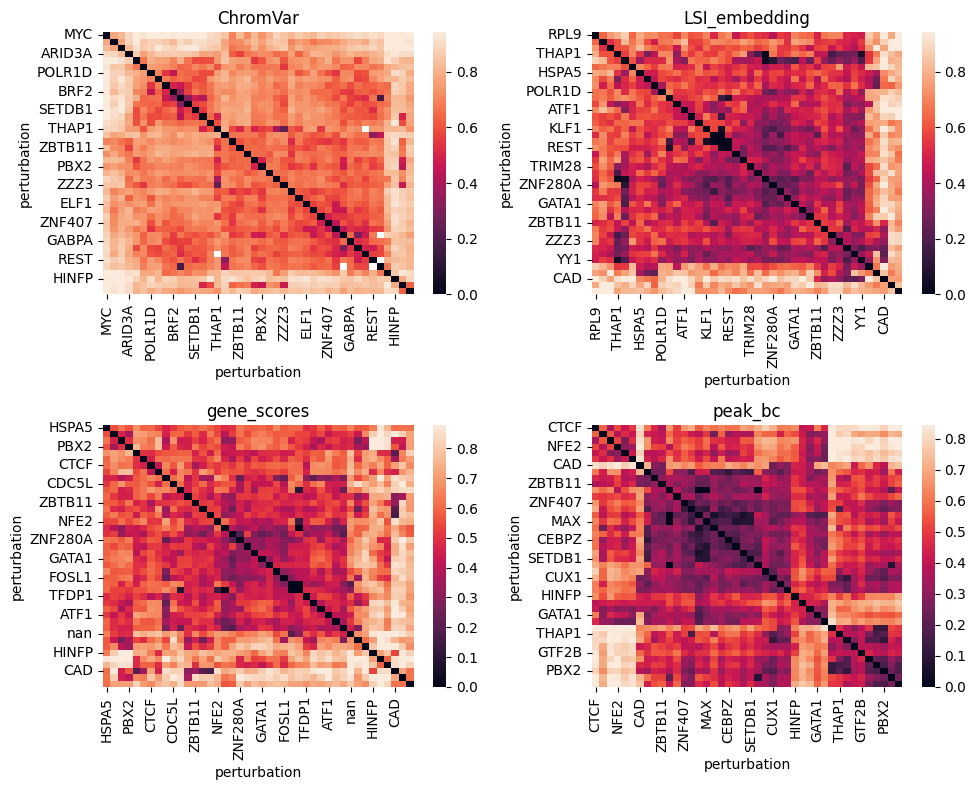

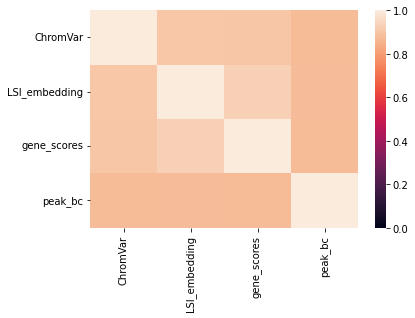

In [43]:
for dataset in datasets_atac:
    print(dataset)
    # compute e-distances in each feature
    eds = {}
    for feature in tqdm(features):
        adata = sc.read(TEMPDIR / f'tmp_ATAC_data_{dataset}_feature_{feature}.h5')
        obsm_key = [x for x in adata.obsm.keys() if feature in x][0]  # select feature embedding
        ed = edist(adata, obs_key='perturbation', obsm_key=obsm_key, flavor=1, verbose=False)
        eds[feature] = cluster_matrix(ed.fillna(0), 'both')
    
    # plot pairwise e-distances
    fig, axss = pl.subplots(2,2,figsize=(10,8), dpi=100)
    for obsm_key, ax in zip(eds.keys(), np.ravel(axss)):
        M = cluster_matrix(eds[obsm_key], 'both')
        M = np.log1p(M)
        M = M/np.max(np.max(M))
        sns.heatmap(M, robust=True, ax=ax)
        ax.set_title(obsm_key)
    pl.tight_layout()
    pl.show()
    
    # kendall
    df = pd.DataFrame({feature: eds[feature].loc['control'] for feature in features})
    pcorr = df.corr('pearson')
    sns.heatmap(pcorr, vmin=0);